<a href="https://colab.research.google.com/github/NamanChanduka/GNR/blob/main/GNR638-13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.utils as Utils
import os
import matplotlib.pyplot as plot
import cv2


***Upload gnr_test.tar.xz and gnr_train.tar.xz***

In [3]:
import tarfile
my_tar = tarfile.open('gnr_train.tar.xz')
my_tar.extractall('./data/train') # specify which folder to extract to
my_tar.close()
my_tar = tarfile.open('gnr_test.tar.xz')
my_tar.extractall('./data/test') # specify which folder to extract to
my_tar.close()

In [4]:
def get_images(path):
  Images = []
  Labels = []

  for labels in os.listdir(path):
    if os.path.isdir(path+labels):
      if labels == 'basketball_court':
        label = 0
      elif labels == 'bridge':
        label = 1
      elif labels == 'crosswalk':
        label = 2
      elif labels == 'golf_course':
        label = 3
      elif labels == 'oil_well':
        label = 4
      elif labels == 'overpass':
        label = 5
      elif labels == 'railway':
        label = 6
      elif labels == 'runway':
        label = 7
      elif labels == 'swimming_pool':
        label = 8
      elif labels == 'tennis_court':
        label = 9

      for image in os.listdir(path+labels):
        img = cv2.imread(path+labels+'/'+image)
        img = cv2.resize(img, (256, 256))
        Images.append(img)
        Labels.append(label)

    else:

      for image in os.listdir(path):
        img = cv2.imread(path+'/'+image)
        img = cv2.resize(img, (256, 256))
        Images.append(img)
      break
  return Images, Labels


In [5]:
Images, Labels = get_images('./data/train/train/') 
Images = np.array(Images) 
Labels = np.array(Labels)

print("Shape of Images array is:",Images.shape)
print("Shape of Labels array is:",Labels.shape)

Shape of Images array is: (500, 256, 256, 3)
Shape of Labels array is: (500,)


In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(Images,Labels,test_size=0.2) 
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
gen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range= 0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = "reflect")

gen.fit(x_train)

In [8]:
img_height = 256
img_width = 256

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)
  ]
)

normalization_layer = layers.Rescaling(1./255)

In [12]:
def createmodel():
    model = Models.Sequential()

    #model.add(data_augmentation)
    #model.add(normalization_layer)
    # 1st Convolutional Layer
    model.add(Layers.Conv2D(filters=256, kernel_size=(3,3),padding="Same",activation="relu" , input_shape = (256,256,3)))
    model.add(Layers.MaxPool2D())
    model.add(Layers.BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Layers.Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
    model.add(Layers.MaxPool2D())
    model.add(Layers.BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Layers.Conv2D(filters=128, kernel_size=(3,3),padding="Same",activation="relu"))
    model.add(Layers.MaxPool2D())
    model.add(Layers.BatchNormalization())

    # 4th Convolutional Layer
    model.add(Layers.Conv2D(filters=256,kernel_size = (3,3),padding="Same",activation="relu"))
    model.add(Layers.MaxPool2D())
    model.add(Layers.BatchNormalization())

    # 5th Convolutional Layer
    model.add(Layers.Conv2D(filters=512,kernel_size = (3,3),padding="Same",activation="relu"))
    model.add(Layers.MaxPool2D())
    model.add(Layers.BatchNormalization())
    model.add(Layers.Dropout(0.2))

    model.add(Layers.Flatten())

    # 1st Fully Connected Layer
    model.add(Layers.Dense(256,activation="relu"))

    model.add(Layers.BatchNormalization())
    # 2nd Fully Connected Layer
    model.add(Layers.Dense(128,activation="relu"))

    model.add(Layers.BatchNormalization())
    # Add output layer
    model.add(Layers.Dense(10,activation="softmax"))
    return model

model1 = createmodel()
batch_size = 32

model1.summary()
#Utils.plot_model(model1,to_file='model.png',show_shapes=True)

model1.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 256)     7168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 256)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 256)     1024      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     295040    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)      

In [21]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1, mode='min', min_lr=10**(-13))
mcp_save = ModelCheckpoint('.hi_wt.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=15)



In [14]:
epochs = 100
history = model1.fit(gen.flow(x_train,y_train, batch_size=batch_size), 
                        epochs=epochs, 
                        validation_data = (x_test,y_test),
                        verbose = 1,
                        callbacks=[red_lr, mcp_save, early_stop])

Epoch 1/100
13/13 [==============================] - 11s 739ms/step - loss: 1.3402 - accuracy: 0.5925 - val_loss: 1114.3208 - val_accuracy: 0.1000
Epoch 2/100
13/13 [==============================] - 10s 713ms/step - loss: 0.5431 - accuracy: 0.8375 - val_loss: 466.8052 - val_accuracy: 0.1000
Epoch 3/100
13/13 [==============================] - 10s 707ms/step - loss: 0.3803 - accuracy: 0.8675 - val_loss: 199.6185 - val_accuracy: 0.1000
Epoch 4/100
13/13 [==============================] - 9s 741ms/step - loss: 0.3833 - accuracy: 0.8550 - val_loss: 57.3105 - val_accuracy: 0.1000
Epoch 5/100
13/13 [==============================] - 10s 714ms/step - loss: 0.3529 - accuracy: 0.9025 - val_loss: 46.6394 - val_accuracy: 0.1000
Epoch 6/100
13/13 [==============================] - 9s 704ms/step - loss: 0.3432 - accuracy: 0.8975 - val_loss: 34.2153 - val_accuracy: 0.1000
Epoch 7/100
13/13 [==============================] - 10s 710ms/step - loss: 0.2576 - accuracy: 0.9225 - val_loss: 14.0491 - val_

Text(0.5, 1.0, 'Accuracy Curves')

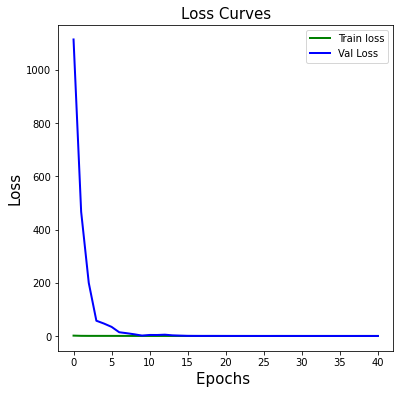

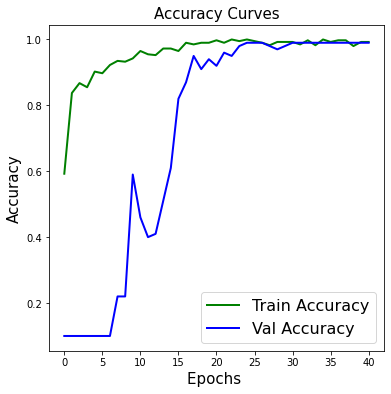

In [15]:
# Loss Curves
plt.figure(figsize=[6,6])
plt.plot(history.history['loss'],'g',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Train loss', 'Val Loss'],fontsize=10)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title('Loss Curves',fontsize=15)

# Accuracy Curves
plt.figure(figsize=[6,6])
plt.plot(history.history['accuracy'],'g',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Train Accuracy', 'Val Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Curves',fontsize=15)

In [16]:
model1.load_weights('.hi_wt.hdf5')

In [17]:
pred_images,pred_labels = get_images('./data/test/')
pred_images = np.array(pred_images)
pred_images.shape

(100, 256, 256, 3)

In [18]:
submission = pd.DataFrame()
a= []
b=[]

for img in os.listdir('./data/test/'):
    image = cv2.imread('./data/test/'+str(img)) 
    image = cv2.resize(image,(256,256)) 
    image = np.reshape(image,[1,256,256,3])
    a.append(img[0:3])
    b.append(np.argmax(model1.predict(image)[0], axis=-1)+1)
    
    
submission['ImageID'] = a
submission['LabelID']= b
    
sub = submission.sort_values(by=['ImageID'])


In [19]:
sub.to_csv('gnr.csv', index=False)